In [ ]:
import numpy as np
import random
from tabulate import tabulate
from matplotlib import pyplot as plt
import math
from enum import Enum

In [ ]:
# constants, these should never have to be changed

POSSIBLE_MOVES = 2
COOP = 0
DEFECT = 1

ENUM_MOVES = ["C","D"]

PAYOFF = [[3, 0], [5, 1]] #PAYOFF[player move][opponent move]

class PenaltyType(Enum):

    NONE = 1

    EXPONENTIAL = 2

    DIVIDED = 3

# these constants can be set depending on the experiment
NUM_TURNS = 30

# need sufficient states to see if state and complexity changes together
# too many states times out in GAP
NUM_MAX_STATES = 3 # for all the tests to work, must be = 3. for the paper i use 15

POP_SIZE = 100
MUTATE_RATE = 0.075

GENERATIONS = 100

ELITISM = True
BOTTLENECK = 70 # amount of new FSMs added to population every breeding cycle


PENALTY = PenaltyType.NONE # For now, need to set which penalty function used manually in Population()
EVOLVE = True

# Divider for the exponent that increases the relative difference for breeding selection
DIVISOR = 100

# WARNING: be sure to rerun tournament and population code after changing constants

In [ ]:
# @title
# Implements a player that moves between states depending on the last move of the opponent
# and returns a move depending on what state it is in.
class FSM:

  def __init__(self, T4T=False, in_move=[], in_next_state=[[]], num_states=NUM_MAX_STATES): #constructor overloading with optional args
    self.state = 0
    self.wins = 0
    # generates an array of num_states columns, with random integers from 0 to POSSIBLE_MOVES (non-inclusive)
    self.move = np.random.randint(0,POSSIBLE_MOVES, num_states)
    # generates numpy array of shape (POSSIBLE_MOVES, num_states) - rows, columns - with random integers from 0 to num_states (non-inclusive)
    self.next_state = np.random.randint(0,num_states,(POSSIBLE_MOVES,num_states))
    self.score = 0 #tallied score from every game played. fitness will be calculated later, by dividing number of matches and other factors

    if T4T: #retaliate with defection
      self.next_state[COOP][0] = 0
      self.next_state[COOP][1] = 0
      self.next_state[DEFECT][0] = 1
      self.next_state[DEFECT][1] = 1
      self.move[0] = COOP
      self.move[1] = DEFECT

    # will overwrite T4T if both are arguments are provided
    # TODO: no guard clauses for invalid input...
    if in_move: # empty lists are false in python
      for i in range(len(in_move)):
        self.move[i] = in_move[i]
    if in_next_state:
      for i in range(len(in_next_state)):
        for j in range(len(in_next_state[0])):
          self.next_state[i][j] = in_next_state[i][j]

    self.first_move = self.move[0]

  def get_move(self):
    return self.move[int(self.state)]

  def change_state(self, oppMove):
    self.state = self.next_state[oppMove][int(self.state)] #get next state

  def reset_state(self):
    # wipe to initial state for next match
    self.state = 0

  # get reachable states for print_GAP/print_FSM
  # basically BFS with a directed graph http://www.cs.cornell.edu/courses/cs2112/2018fa/lectures/lec_traversals/
  # returns array containing the indices of every state that is reachable (starting from 0)
  # returns a set with the index of every state that is reachable
  def get_reachable(self):
    # every player starts in state zero
    visited = set()
    to_visit = [0]
    while (len(to_visit) != 0):
        index = to_visit.pop()
        if self.next_state[COOP][index] not in visited:
            to_visit.append(self.next_state[COOP][index])

        if self.next_state[DEFECT][index] not in visited:
            to_visit.append(self.next_state[DEFECT][index])

        visited.add(index)

    return visited


  def print_FSM(self):
    print("Table mapping current state and opponent move to next state:")
    headers = []
    for i in range(len(self.next_state[0])):
      headers.append("state "+ str(i))

    # tabulate data
    move_label = np.array([["COOP", "DEFECT"]]).T
    temp = np.concatenate((move_label, self.next_state), axis=1) # https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html
    next_state_table = tabulate(temp, headers, tablefmt="fancy_grid")
    print(next_state_table)

    print("\nTable mapping states to player move (COOP = 0, DEFECT = 1):")
    temp = np.concatenate(([["MOVE"]], [self.move]), axis=1) # make into 2D array for tabulate
    player_move_table = tabulate(temp, headers, tablefmt="fancy_grid")
    print(player_move_table)

  def print_GAP(self):

    # easier to add 1 to match GAP indexing with numpy, but the np arrays don't print with commas
    gap_C = np.array(self.next_state[COOP])+1
    gap_D = np.array(self.next_state[DEFECT])+1
    # states {str([i+1 for i in range(len(gap_C))])[1:-1]}
    print(f'C := Transformation({np.array2string(gap_C, separator=", ") });')
    print(f'D := Transformation({np.array2string(gap_D, separator=", ") });')

    moves_for_state = ', '.join(f'"{index}{ENUM_MOVES[item]}"' for index, item in enumerate(self.move))
    print(f'States := [{moves_for_state}];')

  #not just omitting reachable states, but reindexing them
  #mapping each reachable state to its new, minimized state
  #ie. if 0 and 2 are reachable, 2 becomes 1
  # TODO: no unit test for this function
  def print_GAP_reachable(self):
    reachable = self.get_reachable()

    # dict converting reachable states to their smallest version (removing any unreachable states)
    # it shouldn't matter if reachable isn't sorted/in ascending order, since its just a mapping (and 0 state will always be added to the set first)
    map = {val:idx for idx, val in enumerate(reachable)}

    min_next_state = [[],[]]
    min_move = []
    for i in reachable:
      min_next_state[COOP].append(map[self.next_state[COOP][i]])
      min_next_state[DEFECT].append(map[self.next_state[DEFECT][i]])
      min_move.append([map[i], self.move[i]])

    gap_C = np.array(min_next_state[COOP])+1
    gap_D = np.array(min_next_state[DEFECT])+1

    print(f'C := Transformation({np.array2string(gap_C, separator=", ") });')
    print(f'D := Transformation({np.array2string(gap_D, separator=", ") });')

    moves_for_state = ', '.join(f'"{value[0]}{ENUM_MOVES[value[1]]}"' for value in min_move)
    print(f'States := [{moves_for_state}];')

In [ ]:
# @title
class Population:
  def __init__(self, size=0, players=[]):
    self.players=[]
    if players:
      self.size = len(players)
      self.players = players
    else:
      self.size = size
      for i in range(size):
        self.players.append(FSM())

    #keeps track of fitness of all players in the population (for breeding purposes only)
    self.fitness = np.zeros(self.size)
    self.total_turn_count = 0
    self.coop_turn_count = 0
    self.perfect_coop_score = 0

  def turn(p1, p2, pop=None):
    move1 = p1.get_move()
    move2 = p2.get_move()
    p1.score += PAYOFF[move1][move2]
    p2.score += PAYOFF[move2][move1]

    p1.change_state(move2)
    p2.change_state(move1)

    if pop:
      pop.total_turn_count += 1
      #print(pop.total_turn_count)
      pop.perfect_coop_score += PAYOFF[COOP][COOP]
      if move1 == COOP and move2 == COOP:
        pop.coop_turn_count += 1

  def game(p1, p2, turn_count, pop=None):
    starting_score_1 = p1.score
    starting_score_2 = p2.score

    for i in range(turn_count):
      Population.turn(p1, p2, pop=pop)

    #this allows to keep track of the overall score/fitness in the tournament
    #while also comparing whether or not the current game was a win
    score_this_game_1 = p1.score - starting_score_1
    score_this_game_2 = p2.score - starting_score_2

    if score_this_game_1 > score_this_game_2:
      p1.wins += 1
      p2.wins += -1
    elif score_this_game_1 < score_this_game_2:
      p1.wins += -1
      p2.wins += 1
    #ties are zero change

  def tournament(self, turn_count=NUM_TURNS):
    self.total_turn_count = 0
    self.coop_turn_count = 0
    self.perfect_coop_score = 0
    #every FSM should play once against every other FSM
    #print("tournament start")
    for i in range(len(self.players) - 1):
      p1 = self.players[i]
      #print("player 1 is ", i)
      for j in range(i+1, len(self.players)):
        p2 = self.players[j]
        #print("player 2 is ", j)

        Population.game(p1, p2, turn_count, pop=self)
        p1.reset_state()
        p2.reset_state()

  # credit to https://stackoverflow.com/questions/15036009/suppose-i-have-three-weighted-choices-how-do-i-randomly-select-one
  # unbound method. picks a random point in the sum of all fitnesses, and see which FSM's fitness falls into it
  # example of how to call: weighted_choice([.3, .5, .2]) - weights don't have to be normalized
  # doesn't work with negative fitness
  def weighted_choice(weights):
      # random returns a random number from 0 to 1
      choice = random.random() * sum(weights)
      for i, w in enumerate(weights):
          choice -= w
          if choice < 0:
              return i
      # should never reach here
      return i

  # crossover point is exclusive so if cross_point = 1, then [p1[0], p2[1], p2[2]]
  # cross_point should go from [0, len(next_state[0])]
  # where 0 would return a duplicate of p2 and len(next_state[0]) would return a duplicate of p1
  def crossover(p1, p2, cross_point=0):
    # be careful of: https://stackoverflow.com/questions/2739552/2d-list-has-weird-behavor-when-trying-to-modify-a-single-value
    in_move = [COOP]*len(p1.move)
    in_next_state = [[0]*len(p1.next_state[0]) for _ in range(len(p1.next_state)) ]
    # print(len(in_next_state))
    # print(len(in_next_state[0]))

    for i, move in enumerate(p1.move):
      if i < cross_point:
        in_move[i] = p1.move[i]
      else:
        in_move[i] = p2.move[i]

    for j, row in enumerate(p1.next_state):
      for i, state in enumerate(row):
        if i < cross_point:
          in_next_state[j][i] = p1.next_state[j][i]
        else:
          in_next_state[j][i] = p2.next_state[j][i]

    new_player = FSM(in_move=in_move, in_next_state=in_next_state)

    return new_player

  #mutate_point = [which move array index, which state row]
  def mutate(new_player, mutate_point=[0, 0], rate=MUTATE_RATE):

    #will have error if np array and not list, because we evaluate empty list as false in FSM init
    #new_player = FSM(in_next_state=player.next_state.tolist(), in_move=player.move.tolist())
    #actually, since crossover makes a new FSM no need to make a new FSM or reset state or score
    num_state = len(new_player.move)

    for i in range(num_state): #due to pointer shenanigans, for move in new_player.move will not work
      if random.random() < rate:
        #print("old ", new_player.move[i])
        new_player.move[i] = np.random.randint(0,POSSIBLE_MOVES)
        #print("new ", new_player.move[i])
        #new_player.print_FSM()
    for i in range(POSSIBLE_MOVES):
      for j in range(num_state):
        if random.random() < rate:
          #print("old ", new_player.next_state[i][j])
          new_player.next_state[i][j] = np.random.randint(0,num_state)
          #print("new ", new_player.next_state[i][j])
    return new_player

  def breed(self, penalty=PENALTY, evolve=EVOLVE):

    new_players = []

    # null hypothesis, see what happens to complexity when there is no evolutionary pressure
    # also call this "no fitness" in the paper
    # if evolve is False then whatever you set penalty function to doesn't matter
    if evolve == False:
      for i, player in enumerate(self.players):
        self.fitness[i] = 1

    # MAKE SURE PENALTY DOES NOT CAUSE NEGATIVE FITNESS
    # we use POP_SIZE to represent the number of games played
    # (score/DIVISOR)*(score/DIVISOR) just makes the fitness difference more drastic

    # no penalty
    elif penalty == PenaltyType.NONE :
      for i, player in enumerate(self.players):
          self.fitness[i] = (player.score/DIVISOR)*(player.score/DIVISOR)

    # exponential penalty
    # POP_SIZE*number of player's (reachable) states*number of player's (reachable) states
    elif penalty == PenaltyType.EXPONENTIAL:
      for i, player in enumerate(self.players):
        score = max(player.score - POP_SIZE*len(player.get_reachable())*len(player.get_reachable()), 0)
        self.fitness[i] = (score/DIVISOR)*(score/DIVISOR)

    #suggested penalty from conference, to divide by number of states
    #score/states, we don't have to worry about it being negative since it is division
    elif penalty == PenaltyType.DIVIDED:
      for i, player in enumerate(self.players):
        # constant of 5 smoothes the landscape for very low numbers of states, such that we do not always converge on the easiest solution of 1
        self.fitness[i] = player.score/(len(player.get_reachable()) + 5)

    else:
      for i, player in enumerate(self.players):
        self.fitness[i] = 0
        print("remember to set PENALTY constant properly!")


    if ELITISM and BOTTLENECK < len(self.players):
      self.sort_by_score()

      for i in range(len(self.players)):
        if i < BOTTLENECK:
          #fine picking same player twice
          index1 = Population.weighted_choice(self.fitness)
          index2 = Population.weighted_choice(self.fitness)
          new_player = Population.crossover(self.players[index1], self.players[index2])
          new_player = Population.mutate(new_player)

          # self.players[i] = new_player
          new_players.append(new_player)
        else:
          #makes a new player with the same states and moves as the randomly selected old player
          #but this effectively resets their score and state
          # self.players[i] = FSM(in_next_state=self.players[i].next_state.tolist(), in_move=self.players[i].move.tolist())
          new_player = FSM(in_next_state=self.players[i].next_state.tolist(), in_move=self.players[i].move.tolist())
          new_players.append(new_player)

    else:
      #self.players[0].print_FSM()
      for i in range(len(self.players)):
        #fine picking same player twice
        index1 = Population.weighted_choice(self.fitness)
        index2 = Population.weighted_choice(self.fitness)

        new_player = Population.crossover(self.players[index1], self.players[index2])
        new_player = Population.mutate(new_player)

        new_players.append(new_player)

    for i, p in enumerate(new_players):
      self.players[i] = p

    #call this before you breed, sorts players by score
  def sort_by_score(self):
    self.players.sort(key=lambda x: x.score) #ascending order of fitness

  def get_avg_score(self):
    avg_score = 0
    for i in self.players:
      avg_score += i.score
    avg_score = avg_score/len(self.players)
    return avg_score


Pre-set tournament set-up (don't need to run for general use case)

In [ ]:
#pre-set tournament
#testers = [FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(in_move=[1, 1], in_next_state = [[0, 0],[0, 0]]), FSM(in_move=[1, 1], in_next_state = [[0, 0],[0, 0]]), FSM(in_move=[1, 1], in_next_state = [[0, 0],[0, 0]])]
#testers = [FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(in_move=[1, 1], in_next_state = [[0, 0],[0, 0]]), FSM(in_move=[1, 1], in_next_state = [[0, 0],[0, 0]]), FSM(in_move=[1, 1], in_next_state = [[0, 0],[0, 0]])]
testers=[FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True),
         FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True),
         FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True),
         FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True), FSM(T4T=True)]
pop = Population(players=testers)

General Tournament set-up

In [ ]:
#random tournament
pop = Population(POP_SIZE)


Run game

In [ ]:
# make sure to call one of the tournament setup functions above before running this again
# or the first generations won't have their scores reset and will be > 5, which is impossible
# run tournament
coop_percent = np.zeros(GENERATIONS)
fitness = np.zeros(GENERATIONS)

pop.tournament()
coop_percent[0] = (pop.coop_turn_count/pop.total_turn_count)
fitness[0] = pop.get_avg_score()
turn_each_player_gets = (NUM_TURNS*(len(pop.players)-1))

print("INITIAL GENERATION")
pop.sort_by_score()
print("best score is: ", pop.players[-1].score / turn_each_player_gets)
pop.players[-1].print_FSM()
print("avg score is: ", pop.get_avg_score() / turn_each_player_gets)
print("unweighted avg score is: ", pop.get_avg_score() / (len(pop.players)-1))
print("worst score is: ", pop.players[0].score / turn_each_player_gets)

fittest_players = []
all_generations = []

for i in range(1, GENERATIONS):
  pop.breed()
  pop.tournament()
  coop_percent[i] = (pop.coop_turn_count/pop.total_turn_count)
  fitness[i] = pop.get_avg_score()

  # recording the most fit of each generation
  pop.sort_by_score()
  fittest_players.append(pop.players[-1]) # append makes a shallow copy, but our players are new FSM objects each time so its ok
  all_generations.append([player for player in pop.players]) # that's why i need to iterate through and not just append the whole list

  #print(fitness[i] / turn_each_player_gets)

  #for j in pop.players:
    #j.print_FSM()

print("AFTER ", GENERATIONS, " GENERATIONS")
pop.sort_by_score()
print("best score is: ", pop.players[-1].score / turn_each_player_gets)
pop.players[-1].print_FSM()
print("avg score is: ", pop.get_avg_score() / turn_each_player_gets)
print("worst score is: ", pop.players[0].score / turn_each_player_gets)

INITIAL GENERATION
best score is:  3.18989898989899
Table mapping current state and opponent move to next state:
╒════════╤═══════════╤═══════════╤═══════════╕
│        │   state 0 │   state 1 │   state 2 │
╞════════╪═══════════╪═══════════╪═══════════╡
│ COOP   │         0 │         0 │         2 │
├────────┼───────────┼───────────┼───────────┤
│ DEFECT │         2 │         0 │         1 │
╘════════╧═══════════╧═══════════╧═══════════╛

Table mapping states to player move (COOP = 0, DEFECT = 1):
╒══════╤═══════════╤═══════════╤═══════════╕
│      │   state 0 │   state 1 │   state 2 │
╞══════╪═══════════╪═══════════╪═══════════╡
│ MOVE │         1 │         0 │         1 │
╘══════╧═══════════╧═══════════╧═══════════╛
avg score is:  2.2667171717171715
unweighted avg score is:  68.00151515151515
worst score is:  1.5656565656565657
AFTER  100  GENERATIONS
best score is:  2.8373737373737375
Table mapping current state and opponent move to next state:
╒════════╤═══════════╤═══════════╤════

These show some more data on the fly:

In [ ]:
#@title
print("best score is: ", pop.players[-1].score / turn_each_player_gets)
pop.players[-1].print_FSM()

best score is:  2.8373737373737375
Table mapping current state and opponent move to next state:
╒════════╤═══════════╤═══════════╤═══════════╕
│        │   state 0 │   state 1 │   state 2 │
╞════════╪═══════════╪═══════════╪═══════════╡
│ COOP   │         0 │         1 │         2 │
├────────┼───────────┼───────────┼───────────┤
│ DEFECT │         1 │         2 │         1 │
╘════════╧═══════════╧═══════════╧═══════════╛

Table mapping states to player move (COOP = 0, DEFECT = 1):
╒══════╤═══════════╤═══════════╤═══════════╕
│      │   state 0 │   state 1 │   state 2 │
╞══════╪═══════════╪═══════════╪═══════════╡
│ MOVE │         0 │         1 │         1 │
╘══════╧═══════════╧═══════════╧═══════════╛


In [ ]:
#Get GAP code (for best in the population):
pop.players[-1].print_GAP()
pop.players[-1].print_GAP_reachable()

C := Transformation([1, 2, 3]);
D := Transformation([2, 3, 2]);
States := ["0C", "1D", "2D"];
C := Transformation([1, 2, 3]);
D := Transformation([2, 3, 2]);
States := ["0C", "1D", "2D"];


In [ ]:
print(99*30*5)
print(turn_each_player_gets*5)
print(11639/14850)

14850
14850
0.7837710437710438


Create a zip file for GAP processing

In [ ]:
# run this just once at the beginning of the experiment
# creates folder for holding the players
!mkdir allgen_allplayers

In [ ]:
%cd allgen_allplayers

/content/allgen_allplayers


Record fittest players (over multiple generations)

In [ ]:
from google.colab import files
import sys

original_stdout = sys.stdout # Save a reference to the original standard output

# for i in range(1): # you can use this to just test that it works for one gen
for i in range(0,GENERATIONS-1,1):
  fname = 'G'+str(i+1)+'.g'
  with open(fname, 'w') as f:
    #f.write('some content')
    sys.stdout = f # Change the standard output to the file we created.
    fittest_players[i].print_GAP_reachable() #fittest_players is a variable set during 'run game'
    sys.stdout = original_stdout # Reset the standard output to its original value

  # files.download(fname)
  # print(fname)
!zip -r /content/gen_fittest.zip /content/gen_fittest

Records all players in all generations

In [ ]:
# this is just a test to make sure things are working as expected
all_generations[48][0].print_GAP()

C := Transformation([ 1, 14, 13,  3,  8,  4, 14, 14, 10,  5, 11, 14, 12, 11, 10]);
D := Transformation([ 1,  2, 13,  1, 10,  4,  9,  9,  3,  4,  1, 12,  5,  4,  3]);
States := ["0C", "1D", "2D", "3C", "4C", "5C", "6C", "7D", "8C", "9C", "10D", "11D", "12C", "13C", "14C"];


In [ ]:
#records a generation
from google.colab import files
import sys

original_stdout = sys.stdout # Save a reference to the original standard output

for genIdx in range(0,GENERATIONS-1,1):
  for playerIdx in range(POP_SIZE):

    fname = 'G'+str(genIdx+1)+'_P'+str(playerIdx+1)+'.g'
    with open(fname, 'w') as f:
      #f.write('some content')
      sys.stdout = f # Change the standard output to the file we created.
      all_generations[genIdx][-1*(playerIdx+1)].print_GAP_reachable()
      #all_generations is added to during the tournament run
      #G1_P1 will the the fittest player in generation 1, G100_PXX the worst player in generation 100
      sys.stdout = original_stdout # Reset the standard output to its original value

    # files.download(fname)
    print(fname)
!zip -r /allgen_allplayers.zip /content/allgen_allplayers

Streaming output truncated to the last 5000 lines.
updating: content/allgen_allplayers/G37_P72.g (deflated 33%)
updating: content/allgen_allplayers/G33_P67.g (deflated 33%)
updating: content/allgen_allplayers/G39_P50.g (deflated 33%)
updating: content/allgen_allplayers/G22_P19.g (deflated 33%)
updating: content/allgen_allplayers/G21_P48.g (deflated 33%)
updating: content/allgen_allplayers/G59_P32.g (deflated 31%)
updating: content/allgen_allplayers/G82_P18.g (deflated 28%)
updating: content/allgen_allplayers/G82_P40.g (deflated 39%)
updating: content/allgen_allplayers/G83_P22.g (deflated 31%)
updating: content/allgen_allplayers/G17_P50.g (deflated 33%)
updating: content/allgen_allplayers/G43_P93.g (deflated 43%)
updating: content/allgen_allplayers/G4_P84.g (deflated 47%)
updating: content/allgen_allplayers/G96_P4.g (deflated 32%)
updating: content/allgen_allplayers/G73_P64.g (deflated 38%)
updating: content/allgen_allplayers/G39_P83.g (deflated 41%)
updating: content/allgen_allplayers/

Plotting

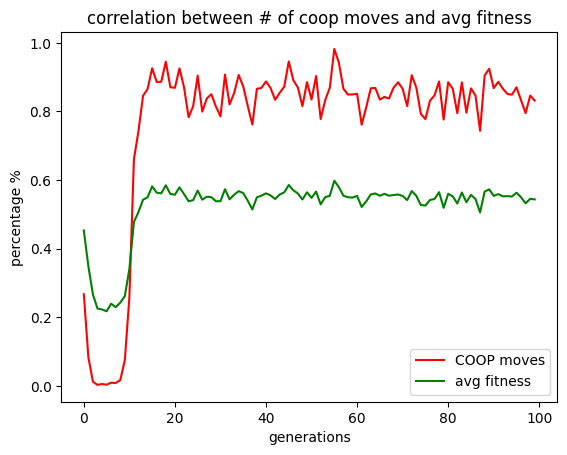

In [ ]:
x = np.arange(0, GENERATIONS)
fig, ax = plt.subplots()
ax.set_xlabel("generations")
ax.set_ylabel("percentage %")
ax.plot(x, coop_percent, color ="red", label="COOP moves")
ax.plot(x, fitness/(5*turn_each_player_gets), color ="green", label="avg fitness")
ax.legend()
ax.set_title('correlation between # of coop moves and avg fitness')
plt.show()

*Set*-up graph and record fitness and cooperation scores (holds up to five runs of the experiment)

In [ ]:
recordFitness = []
recordCoop = []
color = ["#000088", "#00aaff", "#008888", "#88ff00", "#ffdd22", "#ff8800", "#ff0000", "#8822ff"]

In [ ]:
#RUN THIS BEFORE DOWNLOADING THE fitness_coop FILE. actually you should reset it with the prev cell as well
recordFitness.append(fitness)
recordCoop.append(coop_percent)

In [ ]:
#@title
print(recordFitness)
print(recordCoop)

[array([6732.15, 5180.28, 3963.35, 3352.87, 3313.45, 3235.28, 3560.73,
       3414.66, 3608.26, 3886.14, 5066.31, 7098.37, 7529.15, 8060.88,
       8167.42, 8640.11, 8367.2 , 8337.39, 8685.5 , 8312.87, 8278.78,
       8598.19, 8305.75, 7997.46, 8042.75, 8456.79, 8064.3 , 8190.62,
       8174.34, 7995.45, 7997.18, 8516.24, 8078.21, 8277.28, 8432.1 ,
       8350.71, 8017.26, 7640.76, 8166.96, 8238.35, 8339.21, 8249.34,
       8094.15, 8285.33, 8380.39, 8698.65, 8473.19, 8329.67, 8072.14,
       8383.11, 8143.88, 8413.4 , 7858.67, 8174.64, 8229.81, 8883.74,
       8607.36, 8232.54, 8170.5 , 8154.55, 8227.97, 7748.43, 7987.37,
       8290.08, 8332.84, 8233.59, 8315.74, 8235.59, 8265.25, 8288.34,
       8223.48, 8044.27, 8437.  , 8229.06, 7833.09, 7810.54, 8049.67,
       8095.22, 8388.39, 7712.45, 8318.39, 8207.1 , 7898.28, 8375.19,
       7952.93, 8270.88, 8094.14, 7511.04, 8414.03, 8511.96, 8228.16,
       8305.17, 8207.65, 8215.51, 8201.95, 8364.52, 8166.05, 7908.34,
       8101.49, 807

In [ ]:
# check to see if recordFitness is set as expected
for i in range(0, len(recordFitness)):
  for j in range(0, len(recordFitness[0])):
    print(recordFitness[i][j], end=" ")
  print()

  for j in range(0, len(recordCoop[0])):
    print(recordCoop[i][j], end=" ")
  print()

6732.15 5180.28 3963.35 3352.87 3313.45 3235.28 3560.73 3414.66 3608.26 3886.14 5066.31 7098.37 7529.15 8060.88 8167.42 8640.11 8367.2 8337.39 8685.5 8312.87 8278.78 8598.19 8305.75 7997.46 8042.75 8456.79 8064.3 8190.62 8174.34 7995.45 7997.18 8516.24 8078.21 8277.28 8432.1 8350.71 8017.26 7640.76 8166.96 8238.35 8339.21 8249.34 8094.15 8285.33 8380.39 8698.65 8473.19 8329.67 8072.14 8383.11 8143.88 8413.4 7858.67 8174.64 8229.81 8883.74 8607.36 8232.54 8170.5 8154.55 8227.97 7748.43 7987.37 8290.08 8332.84 8233.59 8315.74 8235.59 8265.25 8288.34 8223.48 8044.27 8437.0 8229.06 7833.09 7810.54 8049.67 8095.22 8388.39 7712.45 8318.39 8207.1 7898.28 8375.19 7952.93 8270.88 8094.14 7511.04 8414.03 8511.96 8228.16 8305.17 8207.65 8215.51 8201.95 8364.52 8166.05 7908.34 8101.49 8075.87 
0.26741414141414144 0.08397979797979797 0.012538720538720538 0.003239057239057239 0.005925925925925926 0.0039124579124579124 0.009717171717171718 0.008767676767676768 0.0172996632996633 0.0750909090909091 0.

In [ ]:
#save fitness and coop rate to a text file
from google.colab import files
import sys

original_stdout = sys.stdout # Save a reference to the original standard output

fname = 'fitness_coop.txt'
with open(fname, 'w') as f:
  #f.write('some content')
  sys.stdout = f # Change the standard output to the file we created.
  for i in range(0, len(recordFitness)):
    for j in range(0, len(recordFitness[0])):
      print(recordFitness[i][j], end=" ")
    print()

    for j in range(0, len(recordCoop[0])):
      print(recordCoop[i][j], end=" ")
    print()
  #all_generations is added to during the tournament run
  #G1_P1 will the the fittest player in generation 1, G100_PXX the worst player in generation 100
  sys.stdout = original_stdout # Reset the standard output to its original value

files.download(fname)
print(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

fitness_coop.txt


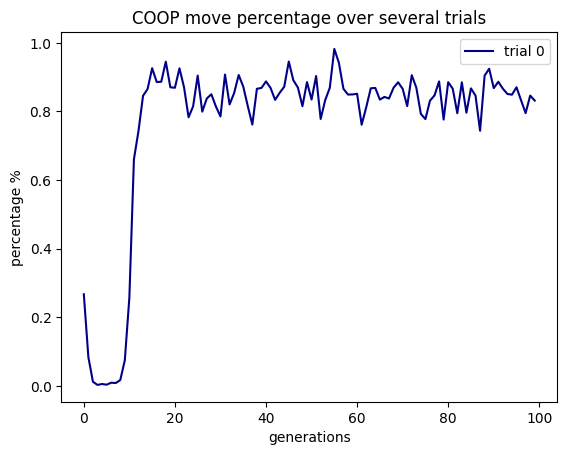

In [ ]:
# lets you compare COOP move percentages over multiple runs of the experiment
fig, ax = plt.subplots()
ax.set_xlabel("generations")
ax.set_ylabel("percentage %")
for i in range(len(recordCoop)):
  ax.plot(x, recordCoop[i], color = color[i], label="trial "+str(i))
ax.legend()
ax.set_title('COOP move percentage over several trials')
plt.show()

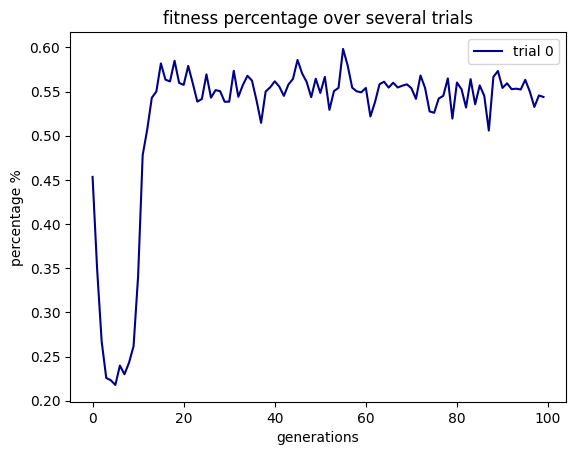

In [ ]:
# lets you compare fitness over multiple runs of the experiment
fig, ax = plt.subplots()
ax.set_xlabel("generations")
ax.set_ylabel("percentage %")
for i in range(len(recordFitness)):
  ax.plot(x, recordFitness[i]/(5*turn_each_player_gets), color = color[i], label="trial "+str(i))
ax.legend()
ax.set_title('fitness percentage over several trials')
plt.show()

Unit Tests

Running any one test cell actually runs all of them, they are just separated for easy viewing and editing (View->Show/hide code)

Change verbosity=2 for more details on failures

In [ ]:
import unittest

State Machine Tests

In [ ]:
#@title
class TestSetup(unittest.TestCase):
  def test_payoff(self):
    '''Make sure payoff function returns the expected score, with the index [player move][opponent move]'''
    self.assertEqual(PAYOFF[0][0], 3)
    self.assertEqual(PAYOFF[0][1], 0)
    self.assertEqual(PAYOFF[1][0], 5)
    self.assertEqual(PAYOFF[1][1], 1)

class TestFSM(unittest.TestCase):
  def setUp(self):
    self.FSM = FSM()

  def test_inst(self):
    '''Test case function for instantiation of FSM'''

    #first state should always be zero
    firstState = self.FSM.state
    expectedState = 0
    self.assertEqual(firstState, expectedState)

    #first move should be valid
    self.assertTrue(self.FSM.first_move == COOP or self.FSM.first_move == DEFECT)

    #ensure all states have a valid move
    self.FSM.move.shape = (NUM_MAX_STATES)
    for i in range(NUM_MAX_STATES): #range is non inclusive of last
      self.assertTrue(self.FSM.move[i] == COOP or self.FSM.move[i] == DEFECT)

    self.FSM.next_state.shape = (POSSIBLE_MOVES, NUM_MAX_STATES) #rows, columns
    for j in range(POSSIBLE_MOVES):
      for i in range(NUM_MAX_STATES):
        self.assertTrue(self.FSM.next_state[j][i] < NUM_MAX_STATES) #should never try going past the last state

    #score should begin at zero
    self.assertEqual(self.FSM.score, 0)

class TestT4T(unittest.TestCase):
  def setUp(self):
    self.FSM = FSM(T4T=True)
    self.assertTrue(NUM_MAX_STATES >= 2) #needs at least two possible outputs

  def test_inst(self):
    '''Test case function for instantiation of tit-for-tat strategy'''
    firstState = self.FSM.state
    expectedState = 0
    self.assertEqual(firstState, expectedState)

  def test_nextMove(self):
    '''Test if tit-for-tat strategy works as expected'''

    #state 0 to 0
    self.FSM.change_state(COOP)
    move = self.FSM.get_move()
    self.assertEqual(move, COOP)
    self.assertEqual(self.FSM.state, 0)

    #state 0 to 1
    self.FSM.change_state(DEFECT)
    move = self.FSM.get_move()
    self.assertEqual(move, DEFECT)
    self.assertEqual(self.FSM.state, 1)

    #state 1 to 1
    self.FSM.change_state(DEFECT)
    move = self.FSM.get_move()
    self.assertEqual(move, DEFECT)
    self.assertEqual(self.FSM.state, 1)

    #state 1 to 0
    self.FSM.change_state(COOP)
    move = self.FSM.get_move()
    self.assertEqual(move, COOP)
    self.assertEqual(self.FSM.state, 0)

class TestHardcoded(unittest.TestCase):

  def test_get_move(self):
    '''Test case for get_move() of FSM'''
    in_move = [1]
    in_next_state = [[0],[0]]
    self.FSM = FSM(in_move=in_move, in_next_state=in_next_state)
    get_move = self.FSM.get_move()
    self.assertTrue(get_move == DEFECT)

  def test_oneState(self):
    '''Test case function for instantiation of FSM with hardcoded moveset and values, one state'''

    in_move = [1]
    in_next_state = [[0],[0]]
    self.FSM = FSM(in_move=in_move, in_next_state=in_next_state)
    #self.FSM.print_FSM()

    #see if moves are as expected
    self.assertTrue(self.FSM.first_move == DEFECT)

    self.FSM.change_state(DEFECT)
    move = self.FSM.get_move()
    self.assertEqual(move, DEFECT)
    self.assertEqual(self.FSM.state, 0)

    self.FSM.change_state(COOP)
    move = self.FSM.get_move()
    self.assertEqual(move, DEFECT)
    self.assertEqual(self.FSM.state, 0)

    #ensure all states have a valid move
    self.FSM.move.shape = (NUM_MAX_STATES)
    for i in range(NUM_MAX_STATES): #range is non inclusive of last
      self.assertTrue(self.FSM.move[i] == COOP or self.FSM.move[i] == DEFECT)

    self.FSM.next_state.shape = (POSSIBLE_MOVES, NUM_MAX_STATES) #rows, columns
    for j in range(POSSIBLE_MOVES):
      for i in range(NUM_MAX_STATES):
        self.assertTrue(self.FSM.next_state[j][i] < NUM_MAX_STATES) #should never try going past the last state

    #score should begin at zero
    self.assertEqual(self.FSM.score, 0)


  def test_multiState(self):
    '''Test case function for instantiation of FSM with hardcoded moveset and values, multi state'''
    in_move = [1, 1, 0]
    in_next_state = [[2, 2, 2],[1, 0, 0]]
    if len(in_move) > NUM_MAX_STATES: #test is sometimes not viable if we don't allow enough states
      return

    self.FSM = FSM(in_move=in_move, in_next_state=in_next_state)
    #self.FSM.print_FSM()

    #see if moves are as expected
    self.assertTrue(self.FSM.first_move == DEFECT)

    self.FSM.change_state(DEFECT)
    move = self.FSM.get_move()
    self.assertEqual(move, DEFECT)
    self.assertEqual(self.FSM.state, 1)

    self.FSM.change_state(COOP)
    move = self.FSM.get_move()
    self.assertEqual(move, COOP)
    self.assertEqual(self.FSM.state, 2)

    self.FSM.change_state(COOP)
    move = self.FSM.get_move()
    self.assertEqual(move, COOP)
    self.assertEqual(self.FSM.state, 2)

class TestPopulation(unittest.TestCase):

  def test_inst_gen(self):
    '''Test case function for instantiation of Population'''
    self.Pop = Population(size=POP_SIZE)

    #should generate POP_SIZE FSMs as players.
    #the starting state of every player should be zero
    self.assertEqual(self.Pop.size, POP_SIZE)
    self.assertEqual(len(self.Pop.players), POP_SIZE)
    for i in range(POP_SIZE):
      self.assertEqual(self.Pop.players[i].state, 0)

  @unittest.skipIf(NUM_MAX_STATES < 3, 'this test will fail if NUM_MAX_STATES < 3, not enough states for last FSM')

  def test_inst_set(self):
    '''Test case function for instantiation of Population with preset FSMs'''
    #T4T, maligned, fool-me-twice
    players = [FSM(T4T=True), FSM(in_move=[1], in_next_state = [[0],[0]]), FSM(in_move=[0,0,1], in_next_state = [[0, 0, 0],[1, 2 ,2]])]

    self.Pop = Population(size=0, players=players)
    self.assertEqual(self.Pop.size, len(players))
    self.assertEqual(len(self.Pop.players), len(players))
    for i in range(self.Pop.size):
      self.assertEqual(self.Pop.players[i].state, 0)

    self.assertEqual(self.Pop.players[2].move[0], COOP)
    self.assertEqual(self.Pop.players[2].move[1], COOP)
    self.assertEqual(self.Pop.players[2].move[2], DEFECT)

    self.assertEqual(self.Pop.players[2].score, 0)

    Population.game(self.Pop.players[1], self.Pop.players[2], turn_count=4)
    expectedScore = PAYOFF[COOP][DEFECT] + PAYOFF[COOP][DEFECT] + PAYOFF[DEFECT][DEFECT] + PAYOFF[DEFECT][DEFECT]
    self.assertEqual(self.Pop.players[2].score, expectedScore)

unittest.main(argv=[''], verbosity=1, exit=False)

.........
----------------------------------------------------------------------
Ran 9 tests in 0.021s

OK


In [ ]:
#@title
class TestTurn(unittest.TestCase):

  def test_malign(self):
    '''Test case function for two turns between T4T and maligned player'''
    self.p1 = FSM(T4T=True)
    #always DEFECTS
    in_move = [1]
    in_next_state = [[0],[0]]
    self.p2 = FSM(in_move=in_move, in_next_state=in_next_state)
    #self.p1.print_FSM()
    #self.p2.print_FSM()

    runningS1 = 0
    runningS2 = 0

    #turn 1 - p1 initially cooperates
    Population.turn(self.p1, self.p2)

    self.assertEqual(self.p1.score, PAYOFF[COOP][DEFECT]) #[player][opp]
    self.assertEqual(self.p2.score, PAYOFF[DEFECT][COOP])

    self.assertEqual(self.p1.state, 1)
    self.assertEqual(self.p2.state, 0)

    runningS1 = self.p1.score
    runningS2 = self.p2.score

    #turn 2 - p1 punishes
    Population.turn(self.p1, self.p2)

    self.assertEqual(self.p1.score, runningS1 + PAYOFF[DEFECT][DEFECT]) #[player][opp]
    self.assertEqual(self.p2.score, runningS2 + PAYOFF[DEFECT][DEFECT])

    self.assertEqual(self.p1.state, 1)
    self.assertEqual(self.p2.state, 0)

    runningS1 = self.p1.score
    runningS2 = self.p2.score

  #TODO: write a slightly more complex test case

class TestGame(unittest.TestCase):
  def test_malign(self):
    '''Test case function for game between T4T and maligned player'''
    self.p1 = FSM(T4T=True)
    #always DEFECTS
    in_move = [1]
    in_next_state = [[0],[0]]
    self.p2 = FSM(in_move=in_move, in_next_state=in_next_state)

    self.assertEqual(self.p1.wins, 0)
    self.assertEqual(self.p2.wins, 0)

    Population.game(self.p1, self.p2, turn_count=10)
    expectedScore1 = PAYOFF[COOP][DEFECT] + PAYOFF[DEFECT][DEFECT]*9
    expectedScore2 = PAYOFF[DEFECT][COOP] + PAYOFF[DEFECT][DEFECT]*9
    self.assertEqual(self.p1.score, expectedScore1)
    self.assertEqual(self.p2.score, expectedScore2)

    self.assertEqual(self.p1.wins, -1) #-1 means a loss
    self.assertEqual(self.p2.wins, 1)

class TestTournament(unittest.TestCase):
  def test_set_tournament(self):
    '''Test case function for a deterministic tournament between T4T, maligned player, and fool-me-twice'''
    players = [FSM(T4T=True), FSM(in_move=[1], in_next_state = [[0],[0]]), FSM(in_move=[0,0,1], in_next_state = [[0, 0, 0],[1, 2 ,2]])]

    self.Pop = Population(size=0, players=players)

    self.assertEqual(self.Pop.players[0].score, 0)
    self.assertEqual(self.Pop.players[1].score, 0)
    self.assertEqual(self.Pop.players[2].score, 0)

    self.Pop.tournament(turn_count=10)

    self.assertEqual(self.Pop.players[1].score, PAYOFF[DEFECT][COOP]*3 + PAYOFF[DEFECT][DEFECT]*17)
    self.assertEqual(self.Pop.players[2].score, PAYOFF[COOP][DEFECT]*2 + PAYOFF[DEFECT][DEFECT]*8 + PAYOFF[COOP][COOP]*10)
    self.assertEqual(self.Pop.players[0].score, PAYOFF[COOP][DEFECT] + PAYOFF[DEFECT][DEFECT]*9 + PAYOFF[COOP][COOP]*10)
    self.assertEqual(self.Pop.players[0].wins, -1)
    self.assertEqual(self.Pop.players[1].wins, 2)
    self.assertEqual(self.Pop.players[2].wins, -1)

  def test_determinant_tournament(self):
    '''Test case function checking that tournaments are deterministic, and reset scores and wins properly'''
    self.Pop = Population()
    for player in self.Pop.players:
      self.assertEqual(player.score, 0)

    self.Pop.tournament(turn_count=10)

    score = [0] * self.Pop.size
    for i, player in enumerate(self.Pop.players):
      score[i] = player.score

    #checks that new tournament has same scores as previous
    self.Pop.tournament(turn_count=10)
    for i, player in enumerate(self.Pop.players):
      self.assertEqual(player.score, score[i])

unittest.main(argv=[''], verbosity=1, exit=False)

.............
----------------------------------------------------------------------
Ran 13 tests in 0.031s

OK


Visualization Tests

In [ ]:
t4t_fsm = FSM(T4T=True)
t4t_fsm.print_FSM()

rand_fsm = FSM()
rand_fsm.print_FSM()

Table mapping current state and opponent move to next state:
╒════════╤═══════════╤═══════════╤═══════════╕
│        │   state 0 │   state 1 │   state 2 │
╞════════╪═══════════╪═══════════╪═══════════╡
│ COOP   │         0 │         0 │         2 │
├────────┼───────────┼───────────┼───────────┤
│ DEFECT │         1 │         1 │         0 │
╘════════╧═══════════╧═══════════╧═══════════╛

Table mapping states to player move (COOP = 0, DEFECT = 1):
╒══════╤═══════════╤═══════════╤═══════════╕
│      │   state 0 │   state 1 │   state 2 │
╞══════╪═══════════╪═══════════╪═══════════╡
│ MOVE │         0 │         1 │         0 │
╘══════╧═══════════╧═══════════╧═══════════╛
Table mapping current state and opponent move to next state:
╒════════╤═══════════╤═══════════╤═══════════╕
│        │   state 0 │   state 1 │   state 2 │
╞════════╪═══════════╪═══════════╪═══════════╡
│ COOP   │         0 │         2 │         1 │
├────────┼───────────┼───────────┼───────────┤
│ DEFECT │         0 │      

In [ ]:
in_next_state = np.array([[0],[0]])
print(in_next_state.shape)

(2, 1)


In [ ]:
temp = np.array([[3, 0], [5, 1]])
new = np.array(temp)

print(temp.shape)
print(new.shape)

(2, 2)
(2, 2)


Test conversion to GAP format

In [ ]:

arr1 = np.array([1,1,2])
arr2 = [2,2,3]

print(f'states {str([i+1 for i in range(len(arr1))])[1:-1]};')
print(f'C := Transformation({ np.array2string(arr1, separator=", ") });')
print(f'D := Transformation({arr2});')
print(f'T := Semigroup([C,D]);')


states 1, 2, 3;
C := Transformation([1, 1, 2]);
D := Transformation([2, 2, 3]);
T := Semigroup([C,D]);
